In [16]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

#Our helpers
from map_helpers import *
from data_helpers import *
from analysis_helpers import *
from helpers import *

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA

import json
import folium
from folium import plugins

#Plot data
import seaborn as sns

%matplotlib inline  

For a better vizualisation of this notebook please read it using the [notebook viewer](https://nbviewer.jupyter.org/github/cgallay/Ada/blob/master/Project/Projet_ADA_M2.ipynb)

# Introduction to the million song Dataset

According to the web site :  https://labrosa.ee.columbia.edu/millionsong "The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.
The core of the dataset is the feature analysis and metadata for one million songs, provided by The Echo Nest. The dataset does not include any audio, only the derived features."

The entire dataset size is 280 GB. We however, based our final analysis on a subset of roughly 100,000 songs. We decided not tu use spark as we could manage a third of the dataset with standard methods and was a sufficiant size for our analysis.

You will see below the first steps of our approach.

### Features description : 
The list of the 54 features present in the dataset, can be found here : https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description
In order not to list them all we choose here to describe the one that seems reelevent to our project: 

 * **artist_name** 
 * **artist latitude:**	float	latitude
 * **artist longitude:** float	longitude
 * **artist_terms:** tags from The Echo Nest in float with range : [0:1]
 * **artist_terms_freq:** similar to mbtags_count but from Echo Nest in float with range : [0:1]  
 * **artist_terms_weight:** same shape as the two previous tags in float with range : [0:1]
 * **loudness:** the overall loudness of a track in decibels (dB). Loudness values in the Analyzer are averaged across an entire track and are useful for comparing relative loudness of segments and tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude).
 * **song_hotttnesss:** according to The Echo Nest, when downloaded (in December 2010) in float with range [0:1]
 * **segments_pitches** The key is a track-level attribute with range : [0:11] and corresponding to one of the 12 keys: C, C#, D, etc. up to B. If no key was detected, the value is -1. The mode is equal to 0 or 1 for “minor” or “major” and may be -1 in case of no result.
 * **segments_timbre** timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness.
 * **tempo:** tempo in BPM according to The Echo Nest
 * **title**
 * **year:** when this song was released, according to musicbrainz.org

# Importing Data
We proceded in two steps:

- Firtly, we loaded the dataset by batches and, for each of them, we extracted the useful features. We saved all the data in pickle formats for faster loading.

- Secondly, we loaded the corresponding pickles according to our needs.

In [ ]:
#Generating all pickles (WARNING: Takes ~2 Hours)
for letter in ['A', 'B', 'C', 'D', 'E', 'F']:
    for half in [1, 2]:
        df = load_song_data(letter, half)
        df1 = select_col(filter_year(df), part=1).dropna()
        df2 = select_col(exctract_timbre_features(filter_hotness(df, 0.001)), part=2).dropna()
        save_pickle_filtered(df1, letter, part=1, half=half)
        save_pickle_filtered(df2, letter, part=2, half=half)
        del df, df1, df2

## Part 0: Exploration

### Year feature 
We started by checking the distribution of the song according to their year of realease

In [7]:
#Load data for part 1
df_song = merge_pickles(['A', 'B', 'C', 'D', 'E', 'F'], 1)

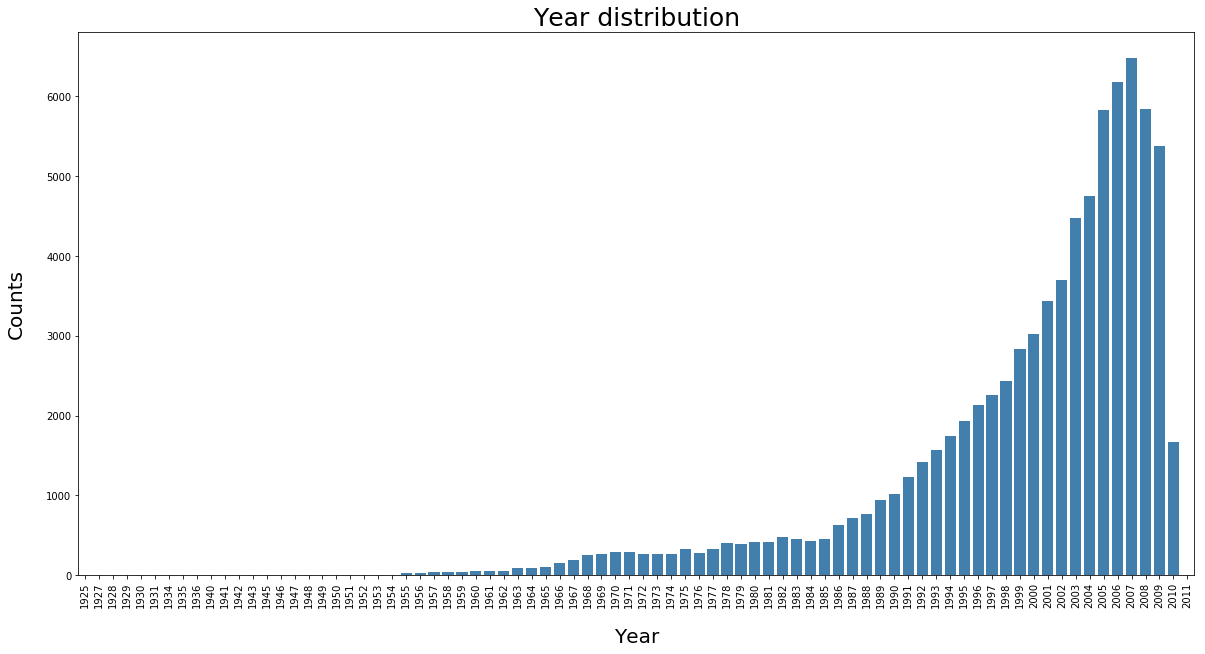

In [4]:
#Plot distribution by year
df = df_song[["artist_name","year"]].groupby('year').count().drop(0)

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plot = sns.barplot(x=df.index, y=df.artist_name, color='#3182bd')
plot.set_title('Year distribution', fontsize= 25 )
plot.set_ylabel('Counts', fontsize=20, labelpad=20)
plot.set_xlabel('Year', fontsize=20, labelpad=20)
plt.savefig('../docs/images/year_distr.png')
plt.show()

From this distribution we can see that the dataset contains much more sample starting from the 90's. This could be related to the emergence of the compact disc technology developed by Sony and Philips and launched in 1982 in which much more informations could be stored.
However, we can see bellow that the number of samples that do not contain a value for the feature "year" is not negligeable and represent almost half of our dataset. It will thus be necessary to take this into account analysing the whole dataset or find a way to extract this information from the web.

## Part 1: Discovering Genre through time

### Genre distribution on map

Here we want to have a look at distribution of artist per genre and per year, to see if it is possible to determine where genre where first recorded.

First of all we show bellow the distribution of artist in all time. We clearly see as already mention before a disproportion of location tag on song from our dataset. Most of the tags are either North America or in EU. As this wont let us detect musical style coming from Asia, South America or Africa, we should still be able to see from which side of the Atlantic the genre originate form.


In [8]:
artistDensityMap(df_song)

### Selecting genre

To detect the genre of a song we based our analysis on the `artist_terms` attribute. Unfortunately this feature doesn't directly contain the genre of the artist (song), but rather terms that people have associated with this artist, most of the time this terms do correspond to genre but they might also be noise (such as a city). An other drawback of this feature, is that there is a lot of different sub-genre. To deal with that, we performed LDA (Latent Dirichlet Analysis) to find 10 super-genre. 

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobservedgroups that explain why some parts of the data are similar. For example, in our case, if observations are terms in the list of each artist_terms feature's track, It would describe the feature as a mixture of a small number of topics and that each term's creation is attributable to one of the feature's topics. The topic here would be a genre and the aim here is thus to group the tags into bigger categories representing a type of music.

In order to match a certain track to a mixture of genre, we will use the above algorithm to be able to classify tags under a same genre abd find the following 10 topics. 
We can observe that the terms are, indeed, related to each other which is what we expected from the tags of a track.

In [13]:
#Train the model
LDA = LatentDirichletAllocation(12, learning_method='batch', random_state=42)
vectorizer, X = get_LDA_vectorizer_features(df_song)
%time X_tranform = LDA.fit_transform(X)

Wall time: 4min 26s


In [14]:
show_top_topic(LDA, vectorizer, top=8)

,0,1,2,3,4,5,6,7
Topic 0,classic rock,pop rock,soft rock,hard rock,80s,psychedelic rock,british,progressive rock
Topic 1,trip hop,downtempo,electronic,techno,electro,breakbeat,electronica,dub
Topic 2,classical,country blues,new age,modern classical,delta blues,chicago blues,texas blues,composer
Topic 3,jazz,funk,smooth jazz,fusion,instrumental,free jazz,contemporary jazz,jazz funk
Topic 4,heavy metal,metal,hardcore,death metal,thrash metal,black metal,hardcore punk,doom metal
Topic 5,rap,hip hop,united states,american,classic country,underground hip hop,new york,underground rap
Topic 6,easy listening,ballad,vocal,pop,soul,chanson,female vocalist,female
Topic 7,experimental,post rock,indie pop,new wave,art rock,shoegaze,experimental rock,noise
Topic 8,house,disco,pop rap,synthpop,europop,trance,dance,italian disco
Topic 9,blues-rock,rockabilly,blues,ska,reggae,country rock,r&b,doo-wop


In [17]:
#Add the super genre to the DataFrame
df_song["genre"] = np.argmax(X_tranform, axis=1)
showMapWithTime(selectGenre(df_song, 2))

Below, we have a distribution of the genre

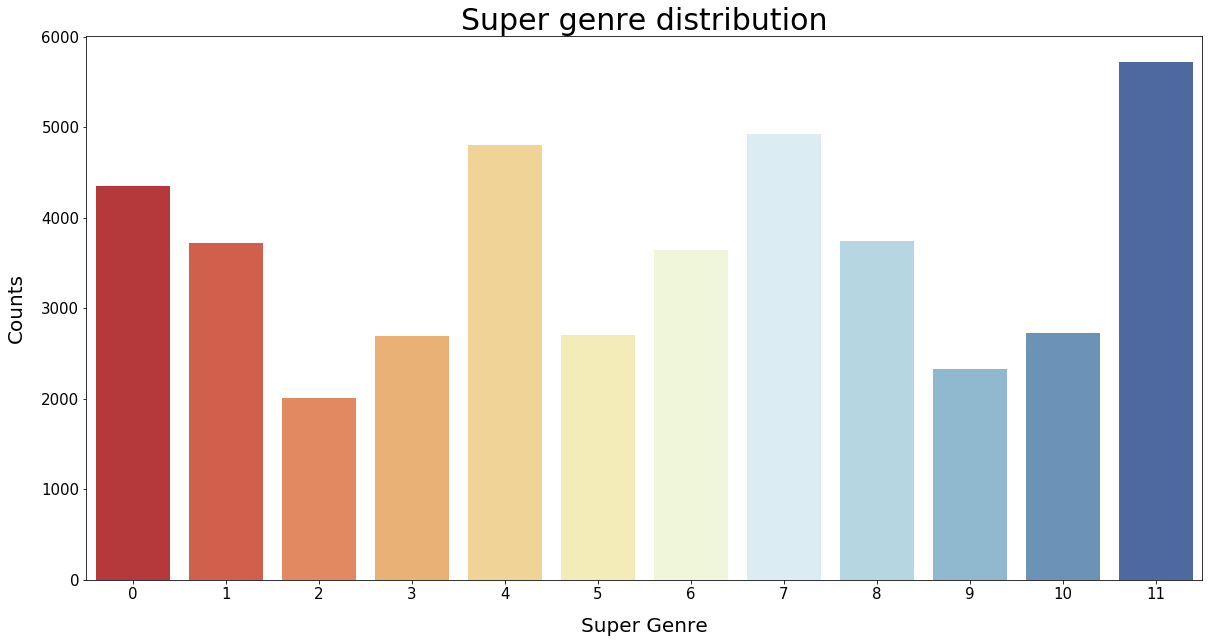

In [20]:
#Plot distribution by year
df = df_song[['genre', 'year']].groupby('genre').count()

plt.figure(figsize=(20,10))
plot = sns.barplot(x=df.index, y=df.year, order=df.index, palette='RdYlBu')
plot.set_title('Super genre distribution', fontsize=30)
plot.set_ylabel('Counts', fontsize=20, labelpad=15)
plot.set_xlabel('Super Genre', fontsize=20, labelpad=15)
plot.xaxis.axes.tick_params(labelsize=15)
plot.yaxis.axes.tick_params(labelsize=15)
plt.savefig('../docs/images/genre_distr.png')
plt.show()

### Extending data through time

When vizualizing the song through time on the map we realised that a song only say one epoch (frame) visible. For us it doesn't reflect the reality as once a song is released it will perdure for a certain amount of time. To simulate that we extend our data with duplicate of the song up to 10 years after it's first apparition. We didn't want to naively duplicate the song as it wont stay a new song for 10 year long, to take that into account, as time pass we decrease the song weight (it's importance at representing the genre into the society)

In [22]:
showMapWithTimeAndWeight(extendsData(selectGenre(df_song, 6)), htmlFilename='outputMap.html')

## Part 2: Discovering Genre through space

### Hotttnesss data collecting
As a lot of songs are unknown and not so popular, we further decided to filter the tracks according to their hotttnesss (popularity) feature. We, then, took the first 30000 songs and completed the data with help of the Deezer and spotify API to add a preview to listen fo each song.

In [ ]:
# loading the corresponding subdataset for the first part
df_song = merge_pickles(['A', 'B', 'C', 'D', 'E', 'F'], 2)
df_song = df_song.sort_values('song_hotttnesss', ascending=False)
df_song = df_song.reset_index()

In [ ]:
df_deezer = add_previews_deezer(df_song[:30000])
df_spotify = add_previews_spotify(df_song[:30000])
df = complete_previews(df_deezer, df_spotify, './pickle_data/complete_song_previews_url_completed_ABCDEF_0-30000.pkl')